In [19]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import matplotlib.pyplot as  plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

SPLIT_SEED = 1
MENS = 'mens'
WOMENS = 'womens'
TEST = 'test'
TRAIN = 'train'

# Columns in Data With Categorical Values- Must LabelEncode them
categorical_cols = ['hitpoint', 'outside.sideline', 'outside.baseline', 'same.side', 
                    'previous.hitpoint', 'server.is.impact.player', 'outcome']

# Columns in the Data That Should Be Scaled
scaled_data = ['serve', 'rally', 'speed', 'net.clearance', 'distance.from.sideline', 'depth', 'player.distance.travelled', 
               'player.impact.depth', 'player.impact.distance.from.center', 'player.depth', 
               'player.distance.from.center', 'previous.speed', 'previous.net.clearance', 
               'previous.distance.from.sideline', 'previous.depth', 'opponent.depth', 
               'opponent.distance.from.center', 'previous.time.to.net']

# Load Data and Return pandas df
def load_tennis_data(gender, train='train'):
    assert gender == 'mens' or gender == 'womens'
    assert train == 'train' or train == 'test'
    csv_path = 'tennis_data/' + gender + '_' + train + '_file.csv'
    return pd.read_csv(csv_path)

# Return Shuffled Training Data- Reorder With ID as first column
def preprocess(data): 
    temp = data 
    temp = shuffle(temp, random_state=SPLIT_SEED)
    cols = temp.columns.tolist()
    new_cols = cols[-4:-3] + cols[0:-4]  + cols[-3:]
    temp = temp[new_cols]
    return temp

# Return df with non-features dropped- ID, Gender, Train
def get_feature_cols(data):
    temp = data 
    temp.drop('id', 1, inplace=True)   
    temp.drop('gender', 1, inplace=True)
    temp.drop('train', 1, inplace=True)
    return temp

# Return ID Column
def get_id(data):
    return data['id']

# Encode Categorical Data
def encode_data(data):
    temp = data
    # Retain All LabelEncoder as a dictionary
    d = defaultdict(LabelEncoder)

    # Encode all the columns
    temp[categorical_cols] = temp[categorical_cols].apply(lambda x: d[x.name].fit_transform(x))
#     print(d['outcome'].classes_)
    # Inverse the encoding
    # temp.apply(lambda x: d[x.name].inverse_transform(x))

    # Using dictionary d to label future data
    # mens_data[categorical_cols].apply(lambda x: d[x.name].transform(x))
    return temp

# Scale Data
def scale_data(data):
    temp = data
    scaler = MinMaxScaler()
    temp[scaled_data] = scaler.fit_transform(temp[scaled_data])
    return temp

# Return Train X, Train Y, Val X, Val Y, ID Columns
def split_train_validation_data(gender, val_size=0.2, random_state=SPLIT_SEED, scaled=False):
    train_data = load_tennis_data(gender, TRAIN)
    train_data= preprocess(train_data)
    train_id = get_id(train_data)
    train_data = get_feature_cols(train_data)
    train_data = encode_data(train_data)
    if scaled:
        train_data = scale_data(train_data)
    # mens_train_data.head()

    # Split into training and validation sets
    train_mens, val_mens = train_test_split(train_data, test_size=val_size, random_state=random_state)

    # Split data into input and outputs
    X_train = train_mens.loc[:, train_mens.columns != 'outcome']
    Y_train = train_mens['outcome']
    X_val = val_mens.loc[:, val_mens.columns != 'outcome']
    Y_val = val_mens['outcome']
#     print(pd.DataFrame(X_train))

    # Reshape Data To Put Into NN
    X_train_np = X_train.values.reshape((-1, 24))
    Y_train_np = Y_train.reshape((-1,1))
    X_val_np = X_val.values.reshape((-1, 24))
    Y_val_np = Y_val.reshape((-1,1))
    return X_train_np, Y_train_np, X_val_np, Y_val_np, train_id

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


# {'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 63}

# split RF data
RF_X_train_m, RF_Y_train_m, RF_X_val_m, RF_Y_val_m, train_id_m = split_train_validation_data(MENS, 0.2, random_state=SPLIT_SEED, scaled=False)

# Model
rfc_model_m = RandomForestClassifier(max_depth=10, n_estimators=14)

# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45],
           "max_depth" : [1, 5, 10, 15, 20],
           "min_samples_leaf" : [1, 2, 4]}

CV_rfc = GridSearchCV(estimator=rfc_model_m, param_grid=param_grid, cv= 10, 
                      verbose=1, scoring='accuracy', n_jobs=4)
CV_rfc.fit(RF_X_train_m, RF_Y_train_m.ravel())
best_param = CV_rfc.best_params_

# RF_model_m = RF_model_m.fit(RF_X_train_m, RF_Y_train_m.ravel())
# RF_prediction = RF_model_m.predict_proba(RF_X_val_m)
# prediction = RF_model_m.predict(RF_X_val_m)

# acc = accuracy_score(RF_Y_val_m, prediction)
# loss = log_loss(RF_Y_val_m, RF_prediction)

# print(RF_prediction)
# print('RF Accuracy: ' + str(acc))
# print('RF Loss: ' + str(loss))
# # print(pd.DataFrame(RF_X_train_m).head())

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 372 tasks      | elapsed:   21.2s
[Parallel(n_jobs=4)]: Done 622 tasks      | elapsed:   53.0s
[Parallel(n_jobs=4)]: Done 750 out of 750 | elapsed:  1.1min finished


In [11]:
print(CV_rfc.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 45}


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

RF_X_train_m, RF_Y_train_m, RF_X_val_m, RF_Y_val_m, train_id_m = split_train_validation_data(MENS, 0.2, random_state=SPLIT_SEED, scaled=False)

# rfc_m = RandomForestClassifier(max_depth = best_param['max_depth'], min_samples_leaf = 
#                                best_param['min_samples_leaf'], n_estimators= 20)
rfc_m = RandomForestClassifier(max_depth = 10, min_samples_leaf = 
                               1, n_estimators= 20)
rfc_m = rfc_m.fit(RF_X_train_m, RF_Y_train_m.ravel())
rfc_m_prediction = rfc_m.predict_proba(RF_X_val_m)
print(rfc_m_prediction)
print(log_loss(RF_Y_val_m, rfc_m_prediction))

[[ 0.04324927  0.92613636  0.03061437]
 [ 0.76418414  0.23381586  0.002     ]
 [ 0.69124308  0.25683761  0.05191931]
 ..., 
 [ 0.00099026  0.05727506  0.94173467]
 [ 0.04375302  0.9137353   0.04251168]
 [ 0.38028707  0.32589791  0.29381502]]
0.450393923027


Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 1s 156us/step - loss: 1.0889 - acc: 0.3930 - val_loss: 1.0527 - val_acc: 0.4630
Epoch 2/50
4000/4000 [==============================] - 0s 67us/step - loss: 1.0373 - acc: 0.4617 - val_loss: 0.9985 - val_acc: 0.4860
Epoch 3/50
4000/4000 [==============================] - 0s 75us/step - loss: 0.9867 - acc: 0.5012 - val_loss: 0.9183 - val_acc: 0.5530
Epoch 4/50
4000/4000 [==============================] - 0s 83us/step - loss: 0.9109 - acc: 0.5558 - val_loss: 0.8338 - val_acc: 0.6080
Epoch 5/50
4000/4000 [==============================] - 0s 74us/step - loss: 0.8510 - acc: 0.6018 - val_loss: 0.7576 - val_acc: 0.6430
Epoch 6/50
4000/4000 [==============================] - 0s 91us/step - loss: 0.8134 - acc: 0.6183 - val_loss: 0.7239 - val_acc: 0.6620
Epoch 7/50
4000/4000 [==============================] - 0s 76us/step - loss: 0.7782 - acc: 0.6332 - val_loss: 0.6906 - val_acc: 0.7250
Epoch 

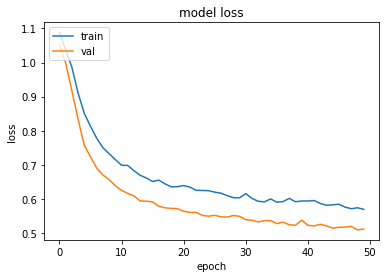

[[  7.69775435e-02   9.21774089e-01   1.24844594e-03]
 [  7.08947837e-01   2.67228603e-01   2.38236170e-02]
 [  7.59854138e-01   2.37499207e-01   2.64672516e-03]
 ..., 
 [  5.03065849e-06   1.64913642e-03   9.98345852e-01]
 [  1.62531242e-01   8.36500168e-01   9.68546432e-04]
 [  2.36402094e-01   7.62766957e-01   8.30998993e-04]]


In [5]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

# Split Data
ANN_X_train_m, ANN_Y_train_m, ANN_X_val_m, ANN_Y_val_m, train_id_m = split_train_validation_data(MENS, 0.2, random_state=SPLIT_SEED, scaled=True)

# Create ANN Model
def create_ANN_model():
    model = Sequential()
    model.add(Dense(15, input_dim=24, activation='relu', kernel_initializer='lecun_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(15, input_dim=24, activation='relu', kernel_initializer='lecun_uniform'))
    model.add(Dropout(0.4))
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.add(Dense(3, activation='softmax', kernel_initializer='lecun_uniform'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

# Build and Train Model
def train_and_evaluate_ANN_model(model, x_train, y_train, xval, yval, epochs, batch_size):
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                         validation_data=(xval, yval))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return model

ANN_model_m = create_ANN_model()
ANN_model_m = train_and_evaluate_ANN_model(ANN_model_m, ANN_X_train_m, ANN_Y_train_m, ANN_X_val_m, 
                                           ANN_Y_val_m, epochs=50, batch_size=32)

# PREDICTION
ANN_m_prediction = ANN_model_m.predict(ANN_X_val_m)
print(ANN_m_prediction)

In [8]:
import scipy
# Ensemble Prediction and Loss
def multiclass_prediction(data):
    prediction = []
    for x in data:
        prediction.append(np.argmax(x))
    return prediction

ensemble_prediction = scipy.stats.mstats.gmean([ANN_m_prediction, rfc_m_prediction], axis=0)
ensemble_loss = log_loss(RF_Y_val_m, ensemble_prediction)
class_prediction = multiclass_prediction(ensemble_prediction)
print(ensemble_prediction)
# print(RF_Y_val_m)
print('Ensemble Accuracy: ' + str(accuracy_score(RF_Y_val_m, class_prediction)))
print('Ensemble Loss: ' + str(ensemble_loss))

[[  5.76994165e-02   9.23952649e-01   6.18226399e-03]
 [  7.36048025e-01   2.49964568e-01   6.90269759e-03]
 [  7.24737135e-01   2.46979206e-01   1.17224636e-02]
 ..., 
 [  7.05809413e-05   9.71876500e-03   9.69627200e-01]
 [  8.43281271e-02   8.74265253e-01   6.41673857e-03]
 [  2.99834386e-01   4.98582149e-01   1.56256196e-02]]
Ensemble Accuracy: 0.832
Ensemble Loss: 0.432407410784


In [22]:
from sklearn.svm import SVC


SVC_X_train_m, SVC_Y_train_m, SVC_X_val_m, SVC_Y_val_m, train_id_m = split_train_validation_data(MENS, 0.2, random_state=SPLIT_SEED, scaled=True)
svc = SVC(probability=True)

param_grid = { 
           "kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
           "gamma" : [1e-1, 1e-2, 1e-3, 1e-4],
           "C" : [1, 10, 100, 1000]}

CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=10, n_jobs=4, verbose=1)
CV_svc.fit(SVC_X_train_m, SVC_Y_train_m.ravel())
print(CV_svc.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   50.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 11.0min
[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed: 36.6min finished


{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [26]:
# {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
svc = SVC(C=10, gamma=0.1, kernel='rbf', probability=True)
svc.fit(SVM_X_train_m, SVM_Y_train_m.ravel())
svm_prediction = svm.predict_proba(SVM_X_val_m)
svm_loss = log_loss(RF_Y_val_m, svm_prediction)
svm_class_prediction = multiclass_prediction(ensemble_prediction)
print('SVC Accuracy: ' + str(accuracy_score(RF_Y_val_m, svm_class_prediction)))

print(svm_prediction)
print(svm_loss)
# SVM

SVC Accuracy: 0.832
[[  3.30302586e-02   9.55858584e-01   1.11111579e-02]
 [  7.66591098e-01   2.18278136e-01   1.51307658e-02]
 [  7.43118646e-01   2.54385605e-01   2.49574893e-03]
 ..., 
 [  4.95836019e-04   7.10855573e-03   9.92395608e-01]
 [  1.46130116e-01   8.51092548e-01   2.77733560e-03]
 [  4.56544841e-01   5.21958005e-01   2.14971540e-02]]
0.515838620809


In [99]:
# Women's Model
X_train_w, Y_train_w, X_val_w, Y_val_w, train_id_w = split_train_validation_data(MENS, 0.2, SPLIT_SEED)
model_w = create_model()
model_w = train_and_evaluate_model(model_w, X_train_w, Y_train_w, X_val_w, Y_val_w, epochs=100, batch_size=32)

NameError: name 'create_model' is not defined

In [ ]:
def create_result_file():
    csv_path = 'tennis_data/AUS_SubmissionFormat.csv'
    return pd.read_csv(csv_path)

    
def append_gender(data, gender):
    return str(data) + '_' + str(gender)

def create_column_ids(mens_id, womens_id):
    mens_test_id_col = mens_id.apply(append_gender, args=('mens',))
    womens_test_id_col = womens_id.apply(append_gender, args=('womens',))

    combined_id = np.concatenate((mens_test_id_col, womens_test_id_col))
    
    return pd.DataFrame(combined_id)

def preprocess_test(gender): 
    data = load_tennis_data(gender, TEST)
    data= preprocess(data)
    # print(mens_test_data.head())
    ids = get_id(data)
    # print(mens_test_id.head())
    data = get_feature_cols(data)
    data = encode_data(data)
    data = scale_data(data)
    data = data.loc[:, data.columns != 'outcome']
    data = data.values.reshape((-1, 24))
    return data, ids

# Preprocess Men's Test Data
test_data_m, test_id_m = preprocess_test(MENS)
# Preprocess Women's Test Data
test_data_w, test_id_w = preprocess_test(WOMENS)
# Create IDs
column_ids = create_column_ids(test_id_m, test_id_w)

In [ ]:
# PREDICTION
m_prediction = prediction(model_m, test_data_m)
m_prediction = pd.DataFrame(m_prediction)
m_prediction.head()

In [ ]:
w_prediction = prediction(model_w, test_data_w)
w_prediction = pd.DataFrame(w_prediction)
w_prediction.tail()

In [ ]:
combined_test_predictions = pd.concat([m_prediction, w_prediction], axis=0)
combined_test_predictions.columns = ['FE', 'UE', 'W']
combined_test_predictions.reset_index(inplace=True, drop=True)
combined_test_predictions.head()

In [ ]:
def format_submission(predictions):
    format_file = create_result_file()
#     format_file['submission_id']
    # result = create_column_ids(mens_test_id, womens_test_id, result)
    final = pd.concat([column_ids, format_file[['train']], predictions], axis=1, )
    final.columns = ['submission_id', 'train', 'FE', 'UE', 'W']
    final = final.set_index(list(final[['submission_id']])).T
    correct_order = list(format_file['submission_id'])
    final_sorted = final[correct_order].T.reset_index()

    # # final[['4314_mens']]
    # # list(result['submission_id'])

    # # final[list(column_ids)]
    # # list(result['submission_id'])
    # # pd.DataFrame(data=final.values, index= list(result['submission_id']))
    # # final.rein dex(list(result['submission_id']))
    # # # # # final = result[['submission_id', 'train']].append(combined_test_predictions)
    # final_sorted

    cols = ['submission_id', 'train', 'UE', 'FE', 'W']
    final_sorted = final_sorted[cols]
    return final_sorted

In [ ]:
final_submission = format_submission(combined_test_predictions)
final_submission.head()

In [ ]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
def save_file(data):
    data.to_csv('Submissions/SubmissionNN' + timestr + '.csv', index=False)
save_file(final_submission)